**NOTE**: This chapter is very basic at this stage, and needs work on text and content. It is slated for expansion. In the meantime, if you're looking for extra information on this topic I recommend [Chapter 27 of *Evolution*](http://evolution-textbook.org/content/free/contents/ch27.html) (free), and [*Inferring Phylogeny* by Felsenstein](http://www.amazon.com/Inferring-Phylogenies-Joseph-Felsenstein/dp/0878931775/ref=sr_1_1?s=books&ie=UTF8&qid=1397401191&sr=1-1&keywords=inferring+phylogenies). You can add suggestions for content, note issues, and follow progress on it updates, in [issue #25](https://github.com/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/issues/25).

# Phylogenetic reconstruction

What: 

The process of inferring the evolutionary relationships between organisms or groups of organisms, and usually representing that information as a tree. 

Why:

1. Make functional inferences about genes. 
2. Understand relationships between organisms (and therefore possible similarities between them). 
3. Compare the composition of communities of organisms (but we'll come back to this).

How:

By comparing traits of extant organisms. In our case, traits are columns in a multiple sequence alignment. Many algorithms and tools exist for achieving this, and they vary widely in runtime and quality of results. We're going to begin by learning about one of the oldest and simplest methods for doing this: *Unweighted Pair Group Method with Arithmetic Mean* or UPGMA. (Don't be scared by the name - it's actually fairly simple.) 

UPGMA is a heirarchical clustering algorithm. It is widely used, though it's application in phylogenetics is usually restricted to building preliminary trees to "guide" the process of multiple sequence alignment, as it makes some assumptions that don't work well for inferring relationships between organsims. We're going to start with it here however for a few reasons. First, the underlying math is very basic, so we don't need to assume anything about your background. Second, there are some other applications of UPGMA that we'll explore later, including grouping samples based on their species compositions. In general, my strategy with teaching this material is to start by giving you a basic introdution into how a process works so you can visualize and do it. From there, we can get more complex.

## Some terminology

Here's the goal (well, *a* goal, but this is the basic idea):

<img src="files/images/basic-rooted-tree1.jpg" width=600>

Each *leaf* (or *tip*, or *terminal node*) in this tree represents a sequence, and the length of the horizonal branches between them indicate their dissimilarity to one another. This is a *rooted tree*, which means that it includes an assumption about the last common ancestor of all sequences represented in the tree. 

Note that the vertical lines in this tree are used for layout purposes only - they do not represent dissimilarity between sequences.

An **unrooted trees**, like the following, doesn't include an assumption about the last common ancestor of all sequences:

<img src="files/images/basic-unrooted-tree1.jpg" width=600>


**Terminal nodes, tips or leaves** extant organisms, frequently called operational taxonomic units or OTUs. OTUs are families of related organisms. 

**Internal nodes** hypothetical ancestors - we postulate their existence but often don’t have direct evidence.

**Clade** a node and all nodes "below" it (i.e., toward the tips)

**Root** the internal node defining the clade which contains all nodes in the tree

**Branches** representative of the distance between the nodes.

<img src="files/images/tree-schematic1.png">


**Monophyletic group** the last common ancestor was a member of the group (e.g., multicellular organisms)

<img src="files/images/tree-monophyly.png">

**Polyphyletic group** the last common ancestor was not a member of the group (e.g., flying animals)

<img src="files/images/tree-polyphyly.png">

We assume that as time progresses, sequences will diverge such that more similar sequences have diverged more recently. The problem of phylogenetic reconstruction however is that we only have the tips. We don't have sequences for the internal nodes, and so we use modern sequences to develop a hypothesis about the evolutionary history of a sequence (and hopefully of the organisms who encode those sequences in their genomes).

<img src="files/images/sequence-evo-tree.png">

How many (rooted) trees are there for `n` sequences? This topic is discussed in detail in Chapter 3 of [Inferring Phylogenies](http://www.amazon.com/Inferring-Phylogenies-Joseph-Felsenstein/dp/0878931775/ref=sr_1_1?s=books&ie=UTF8&qid=1393288952&sr=1-1&keywords=inferring+phylogenies), the definitive text on this topic, but the basic answer is **a lot**.

Because of the massive number of possible trees for any reasonable number of sequences, we can't just search all trees to figure out which one best matches our data. Instead, we must take a heurtistic approach to tree building. Some design features of heurtistic methods that are used in practice are that they:

1. Look at a subset of the possible trees, and don’t guarantee to find the best tree. 
2. Scale to trees for many OTUs (how well they scale depends on the method, and there is a lot of variability)
3. Often provide a single tree, so do not include information on how likely other tree topologies are (we’ll talk about methods, such as bootstrapping, to address this). 


## Distances and distance matrices

Computing a UPGMA tree for a group of sequences relies on first computing *distances* between each pair of those sequences. A *distance*, in this sense, is a technical term. It's a measure of dissimilarity between two items, `x` and `y`, which meets a few criteria:

1. `d(x,y) >= 0` (non-negativity)
2. `d(x,y) = 0` [`iff`](http://en.wikipedia.org/wiki/If_and_only_if) `x = y` (identity of indiscernibles)
3. `d(x,y) = d(y,x)` (symmetry) 
4. `d(x,z) <= d(x,y) + d(y,z)` (triangle inequality)

Let's start with something more similar that sequences. Let's compute the distances between points in a Cartesian plane, to explore what each of these mean.  


(0, 6.5)

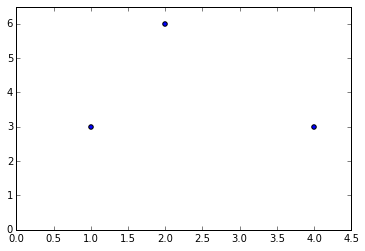

In [1]:
%matplotlib inline
from __future__ import print_function

from IPython.core import page
import matplotlib.pyplot as plt

page.page = print

x_vals = [1, 4, 2]
y_vals = [3, 3, 6]
coordinates = zip(x_vals, y_vals)

fig, ax = plt.subplots()
ax.scatter(x_vals, y_vals)
ax.set_xlim(0)
ax.set_ylim(0)

In [2]:
from scipy.spatial.distance import euclidean
%psource euclidean

def euclidean(u, v):
    """
    Computes the Euclidean distance between two 1-D arrays.

    The Euclidean distance between 1-D arrays `u` and `v`, is defined as

    .. math::

       {||u-v||}_2

    Parameters
    ----------
    u : (N,) array_like
        Input array.
    v : (N,) array_like
        Input array.

    Returns
    -------
    euclidean : double
        The Euclidean distance between vectors `u` and `v`.

    """
    u = _validate_vector(u)
    v = _validate_vector(v)
    dist = norm(u - v)
    return dist



Does Euclidean distance appear to meet the above four requirements of a distance metric?


We can now compute the distances between all of these pairs of coordinates, and we can store these in what's known as a *distance matrix*. 

In [3]:
dm = []

for c1 in coordinates:
    row = []
    for c2 in coordinates:
        row.append(euclidean(c1, c2))
    dm.append(row)

print(dm)

[[0.0, 3.0, 3.1622776601683795], [3.0, 0.0, 3.6055512754639891], [3.1622776601683795, 3.6055512754639891, 0.0]]


The [scikit-bio](https://github.com/biocore/scikit-bio) project defines defines a ``DistanceMatrix`` object that we can use to work with this.

In [4]:
from skbio.stats.distance import DistanceMatrix

dm = DistanceMatrix(dm, map(str,range(3)))

One feature that this gets us is nicer printing.

In [5]:
print(dm)

3x3 distance matrix
IDs:
'0', '1', '2'
Data:
[[ 0.          3.          3.16227766]
 [ 3.          0.          3.60555128]
 [ 3.16227766  3.60555128  0.        ]]


[scikit-bio](https://github.com/biocore/scikit-bio) also provides a convenience wrapper that runs the SciPy *pairwise distance* measures for us and returns a ``DistanceMatrix`` object. We'll use that from here.

In [6]:
from skbio.diversity.beta import pw_distances
help(pw_distances)

Help on function pw_distances in module skbio.diversity.beta._base:

pw_distances(counts, ids=None, metric='braycurtis')
    Compute distances between all pairs of columns in a counts matrix
    
    Parameters
    ----------
    counts : 2D array_like of ints or floats
        Matrix containing count/abundance data where each row contains counts
        of observations in a given sample.
    ids : iterable of strs, optional
        Identifiers for each sample in ``counts``.
    metric : str, optional
        The name of the pairwise distance function to use when generating
        pairwise distances. See the scipy ``pdist`` docs, linked under *See
        Also*, for available metrics.
    
    Returns
    -------
    skbio.DistanceMatrix
        Distances between all pairs of samples (i.e., rows). The number of
        row and columns will be equal to the number of rows in ``counts``.
    
    Raises
    ------
    ValueError
        If ``len(ids) != len(counts)``.
    
    See Also
 

In [7]:
dm = pw_distances(coordinates, metric="euclidean")
print(dm)

3x3 distance matrix
IDs:
'0', '1', '2'
Data:
[[ 0.          3.          3.16227766]
 [ 3.          0.          3.60555128]
 [ 3.16227766  3.60555128  0.        ]]


The conditions of a distance matrix listed above lead to a few specific features: the distance matrix is symmetric (if you flip the upper triangle over the diagonal, the values are the same as those in the lower triangle), the distance matrix is *hollow* (the diagonal is all zeros), and there are no negative values. 

## Computing the distance between pairs of sequences.

Most often, distances between pairs of sequences are derived from a multiple sequence alignment. These differ from the pairwise alignments that we’ve looked at thus far, but use the same underlying algorithms (and we'll be coming back to this in the next chapeter).

Let's load up some aligned sequences, and compute a distance matrix. For now, we'll compute distances between the sequences using the ``hamming`` function that we worked with in the pairwise alignment chapter.

In [8]:
from skbio import Alignment, DNA
aln = Alignment([DNA('ACCGTGAAGCCAATAC', 's1'), 
                 DNA('A-CGTGCAACCATTAC', 's2'),
                 DNA('AGCGTGCAGCCAATAC', 's3'),
                 DNA('AGGGTGCCGC-AATAC', 's4'),
                 DNA('AGGGTGCCAC-AATAC', 's5')])

In [9]:
%psource aln.distances

    def distances(self, distance_fn=None):
        """Compute distances between all pairs of sequences

        Parameters
        ----------
        distance_fn : function, optional
            Function for computing the distance between a pair of sequences.
            This must take two sequences as input (as
            `skbio.sequence.BiologicalSequence` objects) and return a
            single integer or float value. Defaults to
            `scipy.spatial.distance.hamming`.

        Returns
        -------
        skbio.DistanceMatrix
            Matrix containing the distances between all pairs of sequences.

        Raises
        ------
        skbio.util.exception.BiologicalSequenceError
            If ``len(self) != len(other)`` and ``distance_fn`` ==
            ``scipy.spatial.distance.hamming``.

        See Also
        --------
        skbio.DistanceMatrix
        scipy.spatial.distance.hamming

        Examples
        --------
        >>> from skbio.alignment import A

In [10]:
master_dm = aln.distances()
print(master_dm)

5x5 distance matrix
IDs:
's1', 's2', 's3', 's4', 's5'
Data:
[[ 0.      0.25    0.125   0.3125  0.375 ]
 [ 0.25    0.      0.1875  0.375   0.3125]
 [ 0.125   0.1875  0.      0.1875  0.25  ]
 [ 0.3125  0.375   0.1875  0.      0.0625]
 [ 0.375   0.3125  0.25    0.0625  0.    ]]


Once we have these distances, we can cluster the sequences based on their similiaries/dissimilarities. This is the first process that we'll explore for tree building.

**NOTE:** The example below assumes that each value in this distance matrix is multiplied by the sequence length, so we'll do that here and work work with the resulting distance matrix.

In [11]:
master_dm = DistanceMatrix(master_dm.data*16, master_dm.ids)
print(master_dm)

5x5 distance matrix
IDs:
's1', 's2', 's3', 's4', 's5'
Data:
[[ 0.  4.  2.  5.  6.]
 [ 4.  0.  3.  6.  5.]
 [ 2.  3.  0.  3.  4.]
 [ 5.  6.  3.  0.  1.]
 [ 6.  5.  4.  1.  0.]]


## Hierarchical clustering with UPGMA

Unweighted Pair-Group Method with Arithmetic mean

Unweighted: all tip-to-tip distances contribute equally
Pair-group: all branch points lead to exactly two clades
Arithmetic mean: distances to each clade are the mean of distances to all members of that clade

Steps
-----

1. Identify the smallest distance in the matrix and define a clade containing only those members. Draw that clade, and set the *total* branch length to the distance between the tips.
2. Create a new distance matrix with an entry representing the clade created in step 1. 
3. Calculate the distance matrix entries for the clade as the mean distance from each of the tips of the new clade to all other tips in the distance matrix.
4. If there is only one distance (below or above the diagonal) in the distance matrix, use it to connect the remaing clades, and stop. Otherwise repeat step 1. 

Let's start, working from the above distance matrix.

Iteration 1
------------

Step 1.1: The smallest distance in the above matrix is `1.00`, between `s4` and `s5`. So, we'll draw that clade and set each branch length to `0.5`. 

Step 1.2: Next, we'll create a new, smaller distance matrix where the sequences `s4` and `s5` are now represented by a single clade, `(s4, s5)`. 

<img src="files/images/upgma-tree-iter1.png">

In [12]:
iter1_ids = ['s1', 's2', 's3', '(s4, s5)']
iter1_dm = [[0.0,   4.0,  2.0, None], 
            [4.0,   0.0,  3.0, None], 
            [2.0,   3.0,  0.0, None], 
            [None, None, None, None]]

Step 1.3: We'll now fill in the values from the new clade to each of the existing sequences (or clades). The distance will be the mean between a pre-existing clades, and each of the sequences in the new clade. For example, the distance between `s1` and `(s4, s5)` is the mean of the distance between `s1` and `s4` and `s1` and `s5`:

In [13]:
import numpy as np

np.mean([master_dm[0][3], master_dm[0][4]])

5.5

Step 1.3 (continued): Similarly, the distance between `s2` and `(s4, s5)` is the mean of the distance between `s2` and `s4` and `s2` and `s5`:

In [14]:
np.mean([master_dm[1][3], master_dm[1][4]])

5.5

Step 1.3 (continued): And finally, the distance between `s3` and `(s4, s5)` is the mean of the distance between `s3` and `s4` and the distance between `s3` and `s5`:

In [15]:
np.mean([master_dm[2][3], master_dm[2][4]])

3.5

Step 1.3 (continued): If we fill these values in (note that they will be the same above and below the diagonal) the post-iteration 1 distance matrix looks like the following:

In [16]:
iter1_dm = [[0.0, 4.0, 2.0, 5.5], 
      [4.0, 0.0, 3.0, 5.5], 
      [2.0, 3.0, 0.0, 3.5], 
      [5.5, 5.5, 3.5, 0.0]]

iter1_dm = DistanceMatrix(iter1_dm, iter1_ids)
print(iter1_dm)

4x4 distance matrix
IDs:
's1', 's2', 's3', '(s4, s5)'
Data:
[[ 0.   4.   2.   5.5]
 [ 4.   0.   3.   5.5]
 [ 2.   3.   0.   3.5]
 [ 5.5  5.5  3.5  0. ]]


Step 1.4: There is still more than one value below the diagonal, so we start a new iteration.

Iteration 2
------------

Step 2.1: The smallest distance in the above matrix is `2.00`, between `s1` and `s3`. So, we'll draw that clade and set each branch length to `1.0`. 

Step 2.2: Next, we'll create a new, smaller distance matrix where the sequences `s1` and `s3` are now represented by a single clade, `(s1, s3)`. 

<img src="files/images/upgma-tree-iter2.png">

In [17]:
iter2_ids = ['(s1, s3)', 's2', '(s4, s5)']

iter2_dm = [[None, None, None], 
      [None,  0.0, 5.5], 
      [None,  5.5, 0.0]]

Step 2.3: We'll now fill in the values from the new clade to each of the existing sequences (or clades). The distance will be the mean between a pre-existing clades, and each of the sequences in the new clade. For example, the distance between `s2` and `(s1, s3)` is the mean of the distance between `s2` and `s1` and `s2` and `s3`:

In [18]:
np.mean([master_dm[1][0], master_dm[1][2]])

3.5

Step 2.3 (continued): Next, we need to find the distance between `(s1, s3)` and `(s4, s5)`. This is computed as the mean of the distance between `s1` and `s4`, the distance between `s1` and `s5`, the distance between `s3` and `s4`, and the distance between `s3` and `s5`. Note that we are going back to our master distance matrix here for these distances, **not** our iteration 1 distance matrix.

In [19]:
np.mean([master_dm[0][3], master_dm[0][4], master_dm[2][3], master_dm[2][4]])

4.5

Step 2.3 (continued): We can now fill in all of the distances in our iteration 2 distance matrix.

In [20]:
iter2_dm = [[0.0, 3.5, 4.5], 
            [3.5, 0.0, 5.5], 
            [4.5, 5.5, 0.0]]

iter2_dm = DistanceMatrix(iter2_dm, iter2_ids)
print(iter2_dm)

3x3 distance matrix
IDs:
'(s1, s3)', 's2', '(s4, s5)'
Data:
[[ 0.   3.5  4.5]
 [ 3.5  0.   5.5]
 [ 4.5  5.5  0. ]]


Step 2.4: There is still more than one value below the diagonal, so we start a new iteration.

Iteration 3
------------

Step 3.1: The smallest distance in the above matrix is `3.50`, between `(s1, s3)` and `s2`. So, we'll draw that clade and set each branch length to `1.75`. 

Step 3.2: Next, we'll create a new, smaller distance matrix where the clade `(s1, s3)` and the sequence `s2` are now represented by a single clade, `((s1, s3), s2)`. 

<img src="files/images/upgma-tree-iter3.png">

In [21]:
iter3_ids = ['((s1, s3), s2)', '(s4, s5)']

iter3_dm = [[None, None], 
            [None,  0.0]]

Step 3.3: We'll now fill in the values from the new clade to each of the existing sequences (or clades). This is computed as the mean of the distance between `s1` and `s4`, the distance between `s1` and `s5`, the distance between `s3` and `s4`, the distance between `s3` and `s5`, the distance between `s2` and `s4`, and the distance between `s2` and `s5`. Again, note that we are going back to our master distance matrix here for these distances, **not** our iteration 1 or iteration 2 distance matrix.

In [22]:
np.mean([master_dm[0][3], master_dm[0][4], master_dm[2][3], master_dm[2][4], master_dm[1][3], master_dm[1][4]])

4.833333333333333

Step 3.3 (continued): We can now fill in all of the distances in our iteration 3 distance matrix. 

In [23]:
iter3_dm = [[0.0, 4.8], 
            [4.8, 0.0]]

iter3_dm = DistanceMatrix(iter3_dm, iter3_ids)
print(iter3_dm)

2x2 distance matrix
IDs:
'((s1, s3), s2)', '(s4, s5)'
Data:
[[ 0.   4.8]
 [ 4.8  0. ]]


Step 3.4: At this stage, there is only one distance below the diagonal in our distance matrix. So, we can use that distance to draw the final branch in our tree, setting the total branch length to 4.8.

<img src="files/images/upgma-tree-final.png">

[SciPy](http://www.scipy.org/) contains support for running UPGMA and generating *dendrograms* (or basic tree visualizations). We can apply this to our distance matrix as follows. You can explore other options for hierarchical clustering in SciPy [here](http://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) (see the *routines for agglomerative clustering*).  

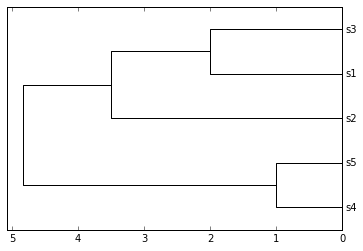

In [24]:
# scipy.cluster.hierarchy.average is an implementation of UPGMA
from scipy.cluster.hierarchy import average, dendrogram
lm = average(master_dm.condensed_form())
d = dendrogram(lm, labels=master_dm.ids, orientation='right', 
               link_color_func=lambda x: 'black')

## Acknowledgements

The material in this section was compiled while consulting the following sources:

1. The Phylogenetic Handbook (Lemey, Salemi, Vandamme)
2. Inferring Phylogeny (Felsenstein)
3. [Richard Edwards’s teaching website](http://www.southampton.ac.uk/~re1u06/teaching/upgma/)
